In [61]:
# imports
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from einops import rearrange

import chromatix.functional as cf

%config InlineBackend.figure_format='retina'

In [63]:
# Settings
shape = (256, 256)
spacing = 0.1
wavelength = 0.532
spectral_density = 1.0
pupil = partial(cf.square_pupil, w = 200 * spacing)

In [64]:
# Init field
field = cf.plane_wave(shape, 
                      spacing, 
                      wavelength, 
                      spectral_density=spectral_density)


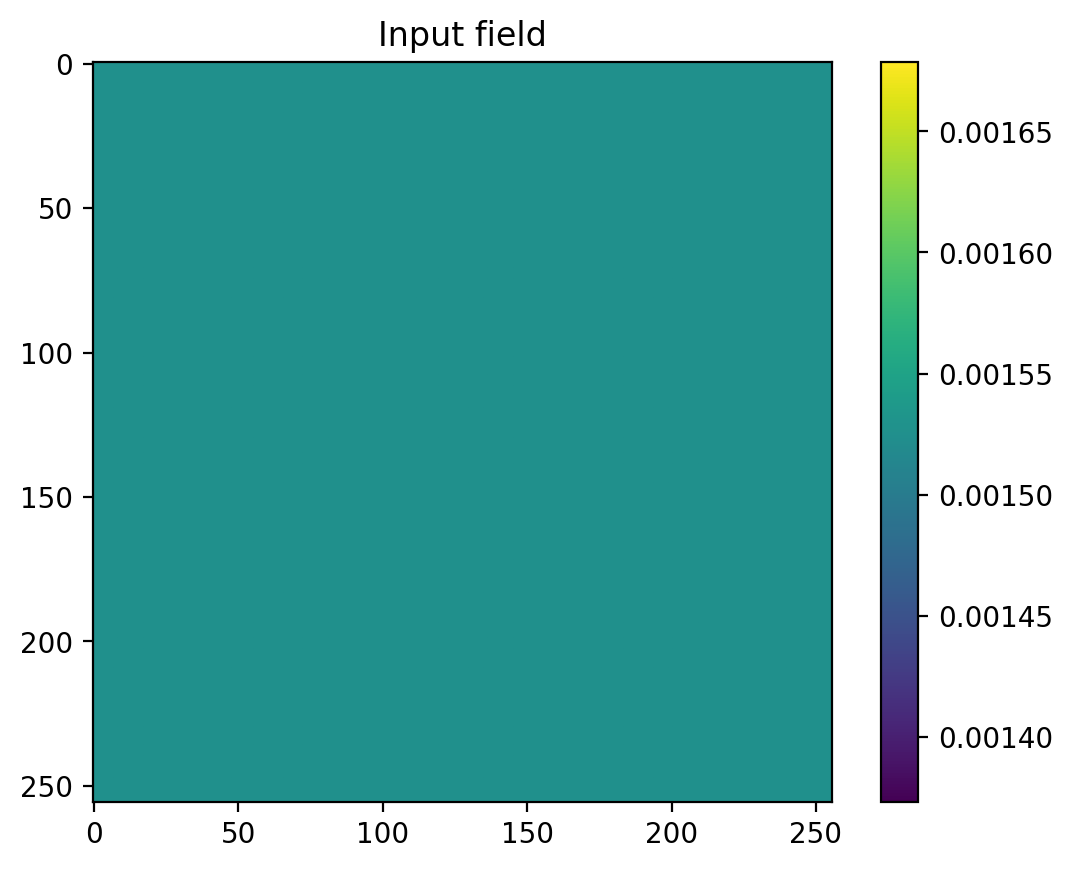

In [65]:
plt.imshow(field.intensity.squeeze())
plt.title("Input field")
plt.colorbar()
plt.show()

In [66]:
# Making sample grid
dx = jnp.array([spacing, spacing])
N_z, N_y, N_x = 256, *shape

grid = jnp.meshgrid(
            jnp.linspace(-N_z // 2, N_z // 2 - 1, num=N_x) + 0.5,
            jnp.linspace(-N_x // 2, N_x // 2 - 1, num=N_z) + 0.5,
            indexing="xy",
        )
grid = dx * rearrange(grid, "c h w -> h w c") 
print(grid.shape)

print(grid[..., 0].min(), grid[..., 0].max())
print(grid[..., 1].min(), grid[..., 1].max())

(256, 256, 2)
-12.75 12.75
-12.75 12.75


In [67]:
# let's put some cylinder in the xz plane
cylinder_pos = jnp.array([[-10, -10.0], [0, 15], [15, 0]]) / 2
cylinder_radius = 2

In [68]:
# Making mask
mask = jnp.zeros((256, 256))
for cylinder in cylinder_pos:
    mask += jnp.linalg.norm(grid - cylinder, axis=-1) < cylinder_radius

mask = jnp.repeat(mask[:, None, :], 256, axis=1)[..., None, None]
print(mask.shape)

# Making sample
n_cylinder = 1.39
n_material = 1.36

sample = jnp.where(mask == 1.0, n_cylinder, n_material)

(256, 256, 256, 1, 1)


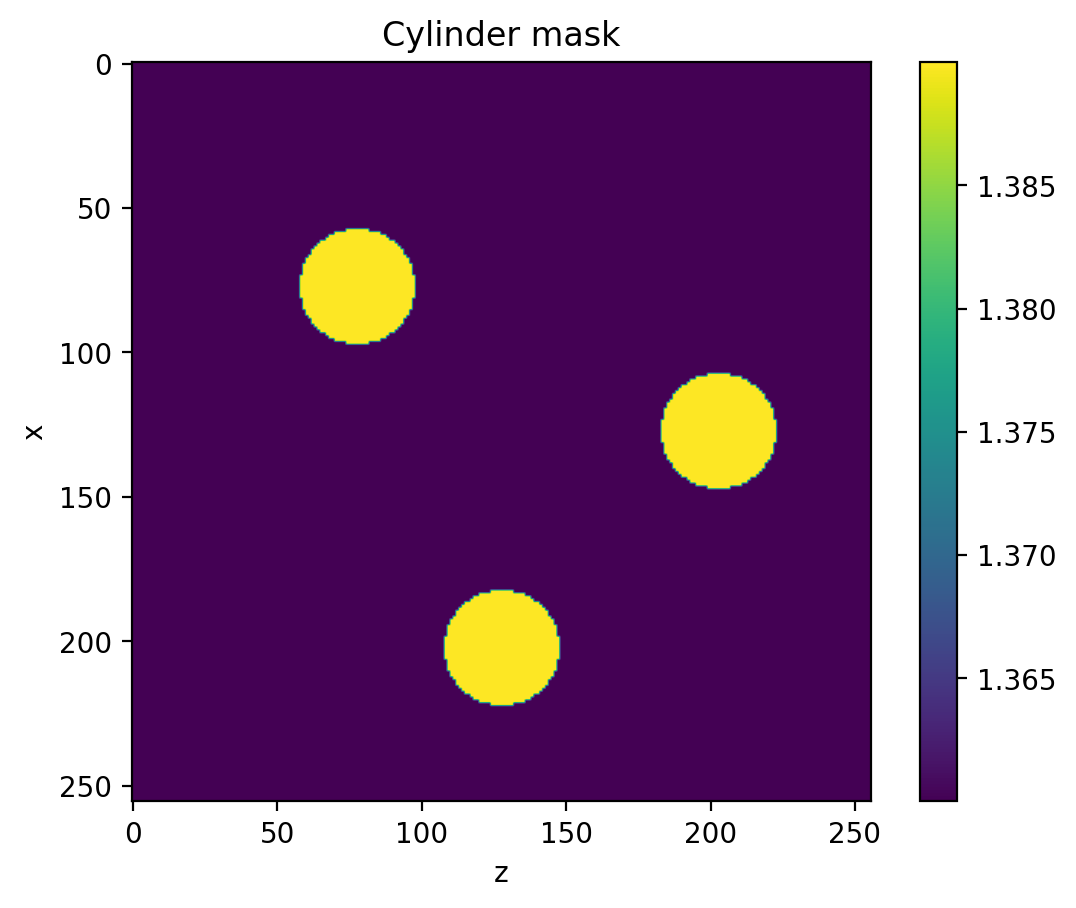

In [69]:
plt.imshow(sample[:, 10].squeeze().T)
plt.xlabel("z")
plt.ylabel("x")
plt.title("Cylinder mask")
plt.colorbar()
plt.show()

# Scalar Modified Born Series

In [71]:
km = 2 * jnp.pi / wavelength
kr = 2 * jnp.pi * sample / wavelength
k0 = jnp.sqrt((jnp.min(kr**2) + jnp.max(kr**2)) / 2)

In [72]:
# We also need a field s for the sources 
s = jnp.zeros_like(field.u, dtype=jnp.complex64)
s = s.at[0].set(field.u[0])
s = s * (km**2 - kr**2)

# We make a field similar to the scattering field
u = s

In [73]:
# Making k grid
shape = jnp.array(s.shape[:3])
dk = 1 / (spacing * shape)

#
k_grid = jnp.meshgrid(
            jnp.linspace(-N_z // 2, N_z // 2 - 1, num=N_z) + 0.5,
            jnp.linspace(-N_y // 2, N_y // 2 - 1, num=N_y) + 0.5,
            jnp.linspace(-N_x // 2, N_x // 2 - 1, num=N_x) + 0.5,
            indexing="ij",
        )
k_grid = jnp.fft.ifftshift(dk * rearrange(k_grid, "c d h w -> d h w c"))

In [74]:
# Getting free parameters
delta = jnp.max(kr**2 - k0**2) + 1e-6 # 1e-6 as epsilon
print(f"Delta is {delta:.2f}")

Delta is 5.75


In [75]:
# Making G
V = (kr**2 - k0**2 - 1j * delta)
G = 1 / (jnp.sum(k_grid**2, axis=-1)[..., None, None] - k0**2 - 1j * delta)
gamma = 1j / delta * V

@jax.jit
def update(u):
    r = jnp.fft.ifftn(G * jnp.fft.fftn(V * u + s, axes=(0, 1, 2)), axes=(0, 1, 2)) - u 

    error = jnp.max(jnp.abs(r))
    rel_error = jnp.max(jnp.abs(r / u))
    return u + gamma * r, {"absolute error": error, "relative error": rel_error}

In [76]:
for iteration in range(2000):
    u, error = update(u)
    if iteration % 50 == 0:
        print(error)

{'absolute error': Array(5.2151785, dtype=float32), 'relative error': Array(1.0268579, dtype=float32)}
{'absolute error': Array(5.2391973, dtype=float32), 'relative error': Array(1.025402, dtype=float32)}
{'absolute error': Array(5.330152, dtype=float32), 'relative error': Array(1.0221485, dtype=float32)}
{'absolute error': Array(5.467673, dtype=float32), 'relative error': Array(1.0194143, dtype=float32)}
{'absolute error': Array(5.6366353, dtype=float32), 'relative error': Array(1.0191795, dtype=float32)}


KeyboardInterrupt: 

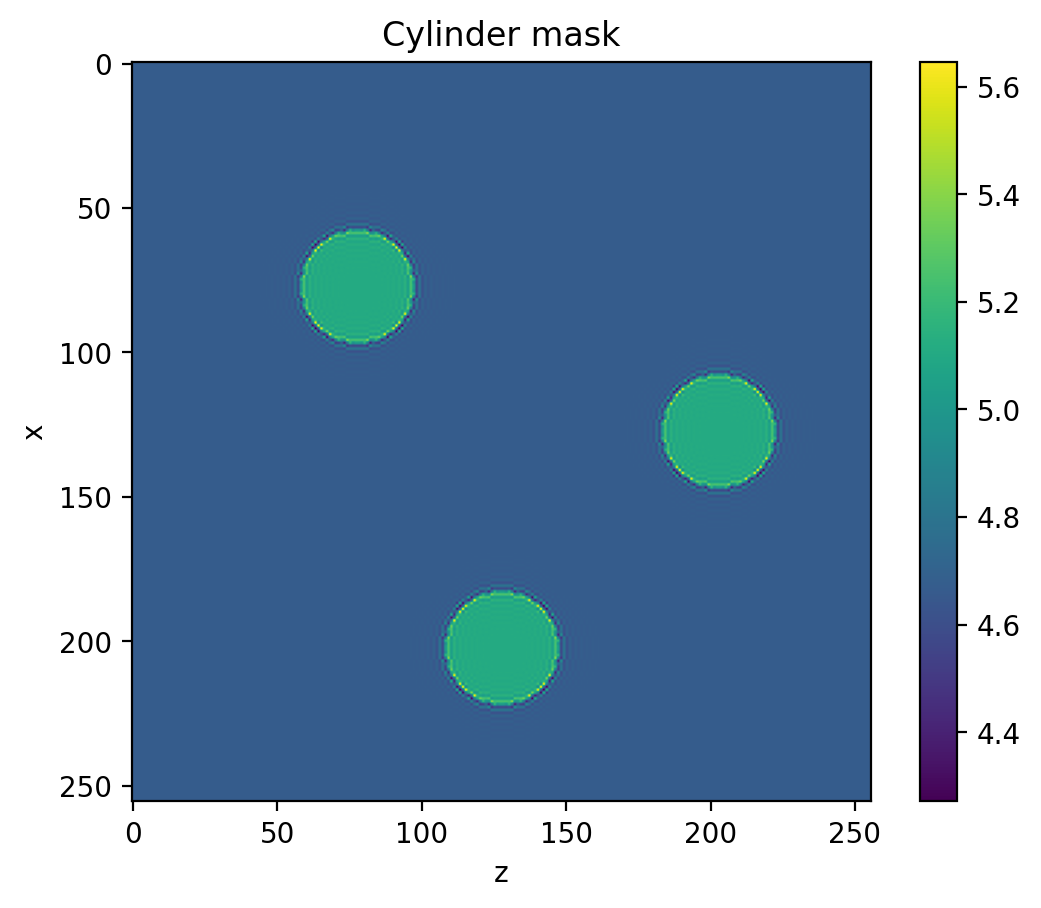

In [77]:
plt.imshow(jnp.abs(u.squeeze())[:, 10].T)
plt.xlabel("z")
plt.ylabel("x")
plt.title("Cylinder mask")
plt.colorbar()
plt.show()